## Лабораторная 7: логические алгоритмы. Бустинг

### Попробуем применить самые сильные на сегодняшний день композиции логических алгоритмов к рассмотренной в лабораторной работе 3 задаче о Титанике. Загрузите данные и подключите необходимые библиотеки:

In [140]:
import numpy as np
import pandas as pd
import warnings
from sklearn import *

from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

In [141]:
import matplotlib.pyplot as plt
%matplotlib inline

In [142]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,7

In [143]:
data = pd.read_csv('data.csv')
data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


## 1
### Замените неизвестные значения и создайте новый сильный признак — приставка к имени (Mr, Mrs, Miss)

In [144]:
data.Age.fillna(-1, inplace=True)
data.Cabin.fillna('unknown', inplace=True)
data.Embarked.fillna('unknown', inplace=True)
data['NamePrefix'] = data.Name.apply(lambda s: 'Mr' 
                                     if s.find('Mr.')>=0 else 'Mrs' 
                                     if s.find('Mrs.')>=0 else 'Miss' 
                                     if s.find('Miss.')>=0 else 'None')

## 2

### Закодируйте номинальные признаки числовыми значениями:

In [145]:
columns = ['Survived','Pclass','NamePrefix','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']
data1 = data.loc[:, columns].copy(deep=True).reset_index(drop=True)
le = preprocessing.LabelEncoder()
for c in ['NamePrefix', 'Sex', 'Cabin', 'Embarked']:
    data1[c] = le.fit_transform(data1[c])


## 3

### В лабораторной работе 3 довольно много студентов с помощью элементарного и неточного метода ближайших соседей достигли точности больше 84%. Примените самые мощные на сегодняшний день алгоритмы `RandomForest`, `CatBoost` от Yandex, `xgboost`, `LightGBM` от Microsoft, основанные на бустинге деревьев. При необходимости настройте их так, чтобы все показали качество больше 83%. Для сравнения выведите на экран лучшую точность работы одного классифицирующего дерева:

In [146]:
# генератор разбиений обучающей выборки на train и test
cv = model_selection.KFold(n_splits=4, shuffle=True, random_state=0)

In [147]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    Tree = tree.DecisionTreeClassifier(max_depth=7, criterion='entropy')
    prediction = model_selection.cross_val_predict(Tree, data1.loc[:, data1.columns!='Survived'], data1['Survived'], cv=cv)
    acc = metrics.accuracy_score(data1['Survived'], prediction)
    print('Tree: {:6.4}'.format(acc))

    RandomForest = ensemble.RandomForestClassifier(n_estimators=150, max_depth=10, random_state=0)
    prediction = model_selection.cross_val_predict(RandomForest, data1.loc[:, data1.columns!='Survived'], data1['Survived'], cv=cv)
    acc = metrics.accuracy_score(data1['Survived'], prediction)
    print('Random forest: {:6.4}'.format(acc))

    XGBoost = xgb.XGBClassifier(max_depth=7, n_estimators=150, random_state=0, eval_metric='rmse')
    prediction = model_selection.cross_val_predict(XGBoost, data1.loc[:, data1.columns!='Survived'], data1['Survived'], cv=cv)
    acc = metrics.accuracy_score(data1['Survived'], prediction)
    print('XGBoost: {:6.4}'.format(acc))

    LightGBM = lgb.LGBMClassifier(verbosity=-1)
    prediction = model_selection.cross_val_predict(LightGBM, data1.loc[:, data1.columns!='Survived'], data1['Survived'], cv=cv)
    acc = metrics.accuracy_score(data1['Survived'], prediction)
    print('LightGBM: {:6.4}'.format(acc))

    CatBoost = CatBoostClassifier(logging_level='Silent', learning_rate=0.015)
    prediction = model_selection.cross_val_predict(CatBoost, data1.loc[:, data1.columns!='Survived'], data1['Survived'], cv=cv)
    acc = metrics.accuracy_score(data1['Survived'], prediction)
    print('CatBoost: {:6.4}'.format(acc))

Tree: 0.8025
Random forest: 0.8215
XGBoost: 0.8182
LightGBM: 0.8238
CatBoost: 0.8305


## 4

### В комментариях попытайтесь объяснить парадокс, почему перечисленные выше супер алгоритмы не смогли победить метод ближайших соседей из 3-й лабораторной работы?

In [148]:
# Особенности задачи, датасета. Т.е. действительно, выполнялась гипотеза компактности, похожие объекты находились в одном классе.

##  5
### Найдите 10 самых информативных признаков, при помощи следующего подхода. Используйте по очереди каждый признак, чтобы по нему предсказать ответ. Нарисуйте на графике столбцовую диаграмму качества предсказаний

In [149]:
method = lgb.LGBMClassifier(verbosity=-1)
# важность признаков
importance = {}
for c in data1.columns:
    if c == 'Survived': continue
    # пытаемся предсказать результат, используя только один столбец
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prediction = model_selection.cross_val_predict(method, 
                                                       data1[c].values.reshape(-1,1),
                                                       data1['Survived'],
                                                       cv=cv)
    importance[c] = metrics.accuracy_score(data1['Survived'], prediction)
cols = list(importance.keys())
fi = np.array([importance[c] for c in cols])

# мы вычитаем из accuracy качество простой модели предсказания: 'все погибнут'
fi = fi - np.sum(data1['Survived']==0)/len(data1)

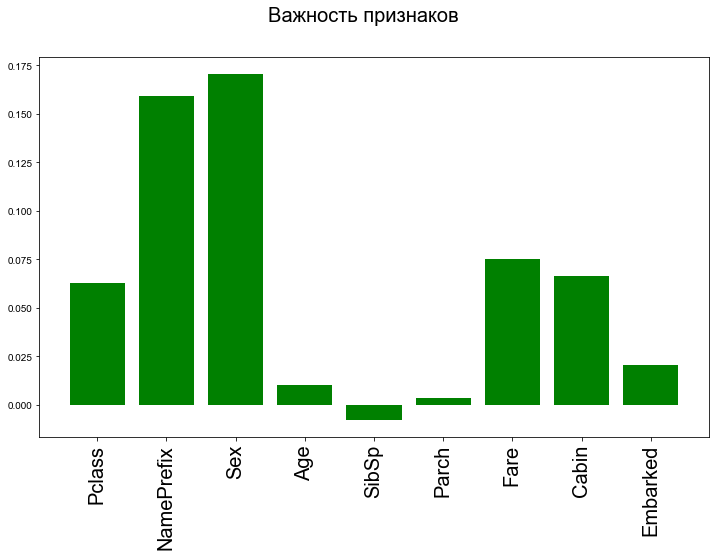

In [150]:
fig = plt.figure()
plt.rc('font', family='Arial')
plt.rcParams['xtick.labelsize'] = 20
plt.bar(np.arange(len(cols)), fi, color='g')
plt.xticks(np.arange(len(cols)), cols, rotation='vertical')
_ = fig.suptitle('Важность признаков', fontsize=20)

## 6
### Судя по графику самыми важными являются признаки пола и приставки к имени. Переберите все возможные пары признаков и выясните, является ли эта пара признаков наилучшей. Выведите на экран 10 лучших пар по убывнию их важности

In [151]:
main_list = sorted(data1.columns)[:-1]

In [152]:
main_list

['Age',
 'Cabin',
 'Embarked',
 'Fare',
 'NamePrefix',
 'Parch',
 'Pclass',
 'Sex',
 'SibSp']

In [153]:
method = lgb.LGBMClassifier(verbosity=-1)
# важность признаков
importance = {}
for i in range(len(main_list)):
  for j in range(i+1, len(main_list)):
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      prediction = model_selection.cross_val_predict(method, 
                                                    data1.loc[:, [main_list[i], main_list[j]]],
                                                    data1['Survived'],
                                                    cv=cv)
    importance[main_list[i] + main_list[j]] = metrics.accuracy_score(data1['Survived'], prediction)
    
cols = list(importance.keys())
fi = np.array([importance[c] for c in cols])

# # мы вычитаем из accuracy качество простой модели предсказания: 'все погибнут'
fi = fi - np.sum(data1['Survived']==0)/len(data1)

In [154]:
topersa = list(zip(cols, fi))
topersa.sort(key=lambda i: i[1], reverse=True)
top10 = topersa[:10]
top10

[('NamePrefixSibSp', 0.1874298540965208),
 ('FareNamePrefix', 0.1806958473625141),
 ('SexSibSp', 0.1806958473625141),
 ('FareSex', 0.17508417508417506),
 ('EmbarkedSex', 0.17059483726150393),
 ('ParchSex', 0.17059483726150393),
 ('AgeSex', 0.16947250280583614),
 ('EmbarkedNamePrefix', 0.16835016835016836),
 ('AgeNamePrefix', 0.164983164983165),
 ('CabinNamePrefix', 0.164983164983165)]

In [155]:
mas = []
names = []
for elem in top10:
  names.append(elem[0])
  mas.append(elem[1])

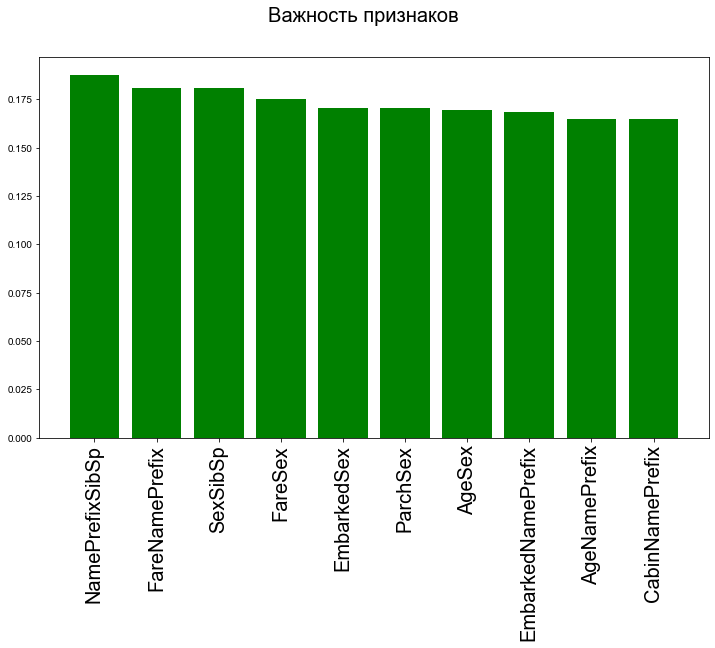

In [156]:
fig = plt.figure()
plt.rc('font', family='Arial')
plt.rcParams['xtick.labelsize'] = 20
plt.bar(np.arange(10), mas, color='g')
plt.xticks(np.arange(10), names, rotation='vertical')
_ = fig.suptitle('Важность признаков', fontsize=20)

In [157]:
#Наилучшей является пара: Префикс перед именем + кол+во братьев, сестер на борту
#На 2 же месте цена билета + префикс